<a href="https://colab.research.google.com/github/Abdulmathin-shaik/vision_v2/blob/main/PatchCore_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install faiss-gpu-cu12

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import faiss  # For efficient nearest-neighbor search
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class MVTecDataset(Dataset):
    def __init__(self, category="bottle", phase="train", img_size=(224, 224)):
        self.phase = phase
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ])
        base_path = f"/content/drive/MyDrive/{category}"  # Replace with your dataset path
        if phase == "train":
            data_path = os.path.join(base_path, "train", "good")
            self.images = [os.path.join(data_path, img) for img in os.listdir(data_path)]
            self.labels = [0] * len(self.images)  # All normal
        else:  # test
            test_path = os.path.join(base_path, "test")
            self.images = []
            self.labels = []
            for label in os.listdir(test_path):
                label_path = os.path.join(test_path, label)
                for img_name in os.listdir(label_path):
                    self.images.append(os.path.join(label_path, img_name))
                    self.labels.append(0 if label == "good" else 1)  # 0: normal, 1: anomaly

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, label

# Load datasets
train_dataset = MVTecDataset(category="bottle", phase="train")
test_dataset = MVTecDataset(category="bottle", phase="test")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
train_dataset[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [ ]:
class PatchCore:
    def __init__(self, backbone="wide_resnet50_2", patch_size=3, sample_ratio=0.1):
        # Load pre-trained backbone
        self.model = models.__getattribute__(backbone)(pretrained=True).to(device)
        self.model.eval()
        self.patch_size = patch_size
        self.sample_ratio = sample_ratio
        self.memory_bank = None

        # Hook to extract intermediate features (e.g., layer2 of WideResNet)
        self.features = []
        def hook(module, input, output):
            self.features.append(output)
        self.model.layer2.register_forward_hook(hook)

    def extract_patches(self, x):
        with torch.no_grad():
            self.features = []
            _ = self.model(x)
            features = self.features[0]  # Shape: (B, C, H, W)
            B, C, H, W = features.shape
            unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
            patches = unfold(features).transpose(1, 2)  # Shape: (B, N_patches, C*patch_size^2)
            return patches.reshape(B, -1, C, self.patch_size, self.patch_size)

    def build_memory_bank(self, loader):
        all_patches = []
        for images, _ in loader:
            images = images.to(device)
            patches = self.extract_patches(images)  # (B, N_patches, C, P, P)
            patches = patches.mean(dim=(3, 4))  # Average over spatial dimensions
            all_patches.append(patches.cpu().numpy())

        all_patches = np.concatenate(all_patches, axis=0)  # (N_total, N_patches, C)
        all_patches = all_patches.reshape(-1, all_patches.shape[-1])  # (N_total * N_patches, C)

        # Subsample patches for efficiency
        n_samples = int(self.sample_ratio * len(all_patches))
        indices = np.random.choice(len(all_patches), n_samples, replace=False)
        self.memory_bank = all_patches[indices]

        # Build FAISS index for fast nearest-neighbor search
        self.index = faiss.IndexFlatL2(self.memory_bank.shape[1])
        self.index.add(self.memory_bank)

    def detect_anomaly(self, image):
        image = image.to(device)
        patches = self.extract_patches(image)  # (1, N_patches, C, P, P)
        patches = patches.mean(dim=(3, 4)).cpu().numpy()  # (1, N_patches, C)
        patches = patches.reshape(-1, patches.shape[-1])  # (N_patches, C)

        # Compute anomaly score (max distance to nearest neighbor in memory bank)
        distances, _ = self.index.search(patches, 1)
        anomaly_score = distances.max()
        return anomaly_score

# Initialize PatchCore
patchcore = PatchCore()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Build memory bank from normal images
print("Building memory bank...")
patchcore.build_memory_bank(train_loader)

# Evaluate on test set
threshold = None  # Set dynamically or via validation
scores = []
labels = []
for image, label in test_loader:
    score = patchcore.detect_anomaly(image)
    scores.append(score)
    labels.append(label.item())

# Simple threshold-based evaluation (tune threshold for best AUC)
scores = np.array(scores)
labels = np.array(labels)
if threshold is None:  # Example: set threshold as 95th percentile of training scores
    train_scores = [patchcore.detect_anomaly(image) for image, _ in train_loader]
    threshold = np.percentile(train_scores, 95)

predictions = (scores > threshold).astype(int)
accuracy = np.mean(predictions == labels)
print(f"Accuracy: {accuracy:.4f}")

# Optional: Compute AUC for better evaluation
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(labels, scores)
print(f"AUC: {auc:.4f}")

Building memory bank...
Accuracy: 0.8554
AUC: 1.0000


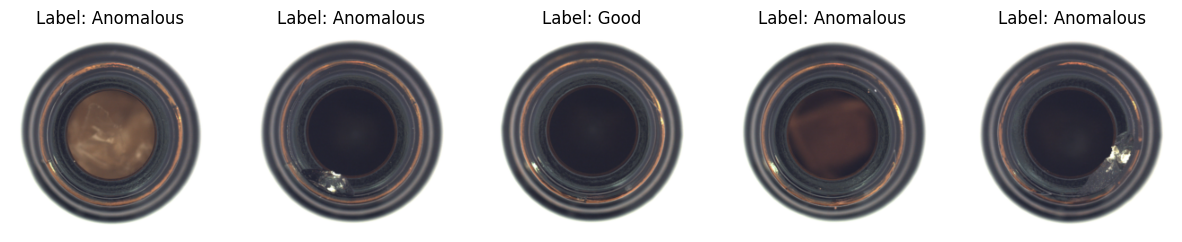

In [ ]:
# prompt: vizualise random images from test

import matplotlib.pyplot as plt
import random

# Visualize random images from the test set
num_images_to_show = 5  # Adjust as needed
random_indices = random.sample(range(len(test_dataset)), num_images_to_show)

fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    image = image.permute(1, 2, 0)  # Reshape for display
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image.numpy(), 0, 1) # Clip values to be within the valid range

    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Good' if label == 0 else 'Anomalous'}")
    axes[i].axis('off')

plt.show()
